In [178]:
# 导入相关包依赖
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 乳腺肿瘤数据集

In [179]:
cancer = pd.read_csv("preprocessing_cancer.csv")
cancer.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


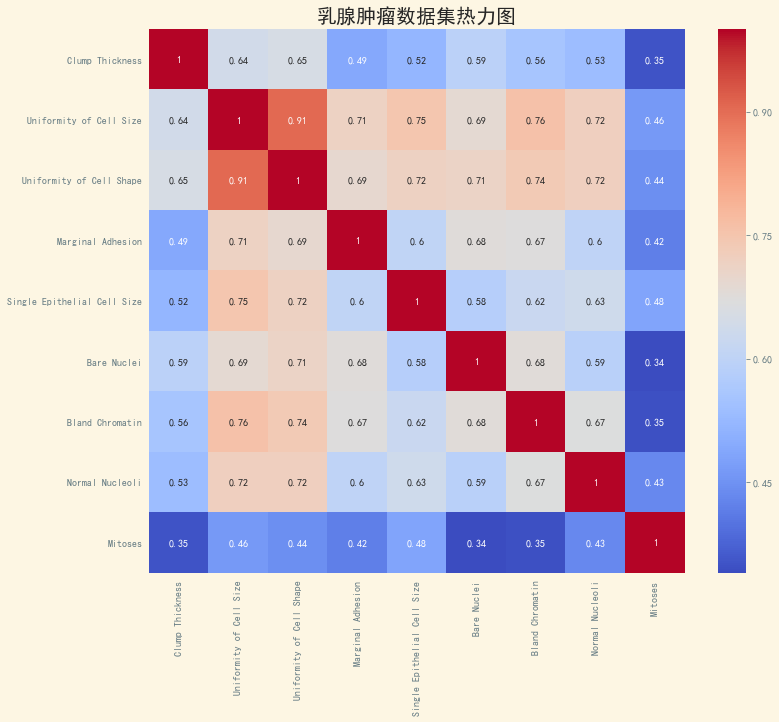

In [180]:
features_mean= list(cancer.columns[0:9])
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 使用热力图呈现features_mean 字段之间的相关性
corr = cancer[features_mean].corr()
plt.figure(figsize=(12,10))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title('乳腺肿瘤数据集热力图',fontsize = 20)
plt.show()

根据热力图可以看出，第二列与其他属性的相关性较强，因此选择 Uniformity of Cell Size（第二列作为回归目标属性），由于第一列和第9列数据与回归目标属性的相关性较弱因此对着两列不予考虑，得到最终的数据集。

In [181]:
# 删除类别属性列
cancer=cancer.drop(['Class'],axis=1)
# 删除相关性较弱的属性列
cancer=cancer.drop(['Clump Thickness'],axis=1)
cancer=cancer.drop(['Mitoses'],axis=1)
cancer.head()

,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli
0,1,1,1,2,1,3,1
1,4,4,5,7,10,3,2
2,1,1,1,2,2,3,1
3,8,8,1,3,4,3,7
4,1,1,3,2,1,3,1


In [182]:
X,y = cancer.drop(['Uniformity of Cell Size'],axis=1),cancer['Uniformity of Cell Size']
X_trains = []
X_tests = []
y_trains = []
y_tests = []
for i in np.arange(0.2,0.8,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30,test_size=(1-i),stratify=y)
    transfer = StandardScaler()
    X_train = transfer.fit_transform(X_train)
    X_test = transfer.fit_transform(X_test)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

# 1.1乳腺肿瘤数据集使用随机森林回归

In [183]:
#构建回归器
my_rfc = RandomForestRegressor(n_estimators=25)
y_predicts = []
#在不同的测试集和训练集上进行训练和预测，预测结果保存在y_predicts中
for i in range(len(X_trains)):
    my_rfc.fit(X_trains[i],y_trains[i])
    y_predict = my_rfc.predict(X_tests[i])
    y_predicts.append(y_predict)

In [184]:
MSEs,MAEs,RMSEs,Rs = [],[],[],[]
for i in range(len(y_tests)):
    MSEs.append(mean_squared_error(y_tests[i],y_predicts[i]))
    MAEs.append(mean_absolute_error(y_tests[i],y_predicts[i]))
    RMSEs.append(np.sqrt(mean_squared_error(y_tests[i],y_predicts[i])))
    Rs.append(r2_score(y_tests[i],y_predicts[i]))

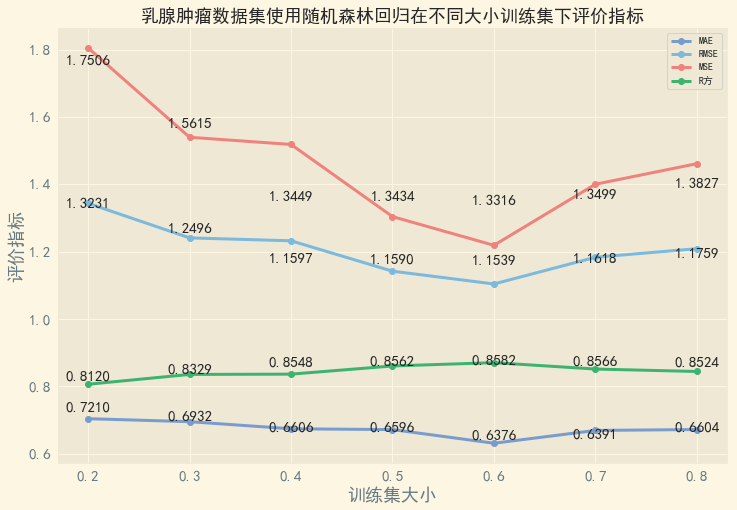

In [186]:
%matplotlib inline
x = list(np.arange(0.2,0.8,0.1))
# 数据处理，保留4位小数
plt.style.use('Solarize_Light2')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.plot(x, MAEs, label='MAE', linewidth=3, color='#789CCE', marker='o',markerfacecolor='#789CCE')
plt.plot(x, RMSEs, label='RMSE', linewidth=3, color='#7bb9dd', marker='o',markerfacecolor='#7bb9dd')
plt.plot(x, MSEs, label='MSE', linewidth=3, color='#EF827D', marker='o',markerfacecolor='#EF827D')
plt.plot(x, Rs, label='R方', linewidth=3, color='#3eb370', marker='o',markerfacecolor='#3eb370')
plt.xlabel('训练集大小',fontsize = 18)
# 纵坐标描述
plt.ylabel('评价指标',fontsize = 18)
# 标题
plt.title('乳腺肿瘤数据集使用随机森林回归在不同大小训练集下评价指标',fontsize = 18)
plt.legend()
# 设置数字标签
for a, b in zip(x, MAE):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, MSE):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, R):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, RMSE):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

# 1.2乳腺肿瘤数据集使用AdaBoost回归

In [187]:
#以决策树回归为基回归器
rgr_tree = DecisionTreeRegressor(max_depth=4)#决策树回归
rgr_ada = AdaBoostRegressor(rgr_tree,n_estimators=300, random_state=25)#AdaBoost回归

y_predicts = []
#在不同的测试集和训练集上进行训练和预测，预测结果保存在y_predicts中
for i in range(len(X_trains)):
    rgr_ada.fit(X_trains[i],y_trains[i])
    y_predict = rgr_ada.predict(X_tests[i])
    y_predicts.append(y_predict)

In [188]:
MSEs,MAEs,RMSEs,Rs = [],[],[],[]
for i in range(len(y_tests)):
    MSEs.append(mean_squared_error(y_tests[i],y_predicts[i]))
    MAEs.append(mean_absolute_error(y_tests[i],y_predicts[i]))
    RMSEs.append(np.sqrt(mean_squared_error(y_tests[i],y_predicts[i])))
    Rs.append(r2_score(y_tests[i],y_predicts[i]))

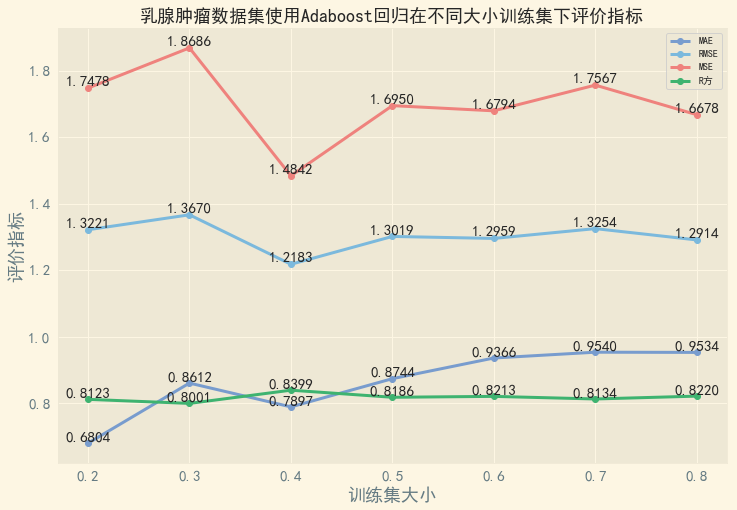

In [190]:
%matplotlib inline
x = list(np.arange(0.2,0.8,0.1))
plt.style.use('Solarize_Light2')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.plot(x, MAEs, label='MAE', linewidth=3, color='#789CCE', marker='o',markerfacecolor='#789CCE')
plt.plot(x, RMSEs, label='RMSE', linewidth=3, color='#7bb9dd', marker='o',markerfacecolor='#7bb9dd')
plt.plot(x, MSEs, label='MSE', linewidth=3, color='#EF827D', marker='o',markerfacecolor='#EF827D')
plt.plot(x, Rs, label='R方', linewidth=3, color='#3eb370', marker='o',markerfacecolor='#3eb370')
plt.xlabel('训练集大小',fontsize = 18)
# 纵坐标描述
plt.ylabel('评价指标',fontsize = 18)
# 标题
plt.title('乳腺肿瘤数据集使用Adaboost回归在不同大小训练集下评价指标',fontsize = 18)
plt.legend()
# 设置数字标签
for a, b in zip(x, MAEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, MSEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, Rs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, RMSEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

# 1.3 算法性能比较

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30,test_size=0.3,stratify=y)
my_rfc = RandomForestRegressor(n_estimators=25)
my_rfc.fit(X_train,y_train)
y_predict_forest = my_rfc.predict(X_test)
MSE_forest = mean_squared_error(y_test,y_predict_forest)
MAE_forest = mean_absolute_error(y_test,y_predict_forest)
RMSE_forest = np.sqrt(mean_squared_error(y_test,y_predict_forest))
R2_forest = r2_score(y_test,y_predict_forest)

In [158]:
#以决策树回归为基回归器
rgr_tree = DecisionTreeRegressor(max_depth=4)#决策树回归
rgr_ada = AdaBoostRegressor(rgr_tree,n_estimators=300, random_state=25)#AdaBoost回归
rgr_ada.fit(X_train,y_train)
y_predict_adaboost = rgr_ada.predict(X_test)
MSE_adaboost = mean_squared_error(y_test,y_predict_adaboost)
MAE_adaboost = mean_absolute_error(y_test,y_predict_adaboost)
RMSE_adaboost = np.sqrt(mean_squared_error(y_test,y_predict_adaboost))
R2_adaboost = r2_score(y_test,y_predict_adaboost)

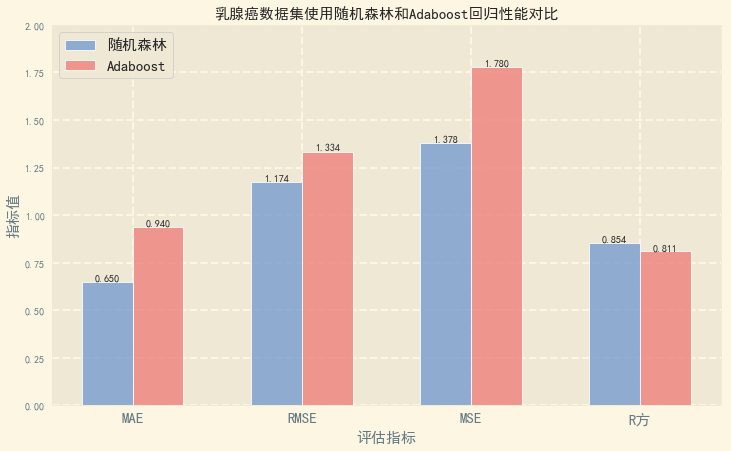

In [159]:
# 对比乳腺癌数据集在随机森林和Adaboost上的性能
forest_list=[MAE_forest,RMSE_forest,MSE_forest,R2_forest]
adaboost_list=[MAE_adaboost,RMSE_adaboost,MSE_adaboost,R2_adaboost]
plt.style.use('Solarize_Light2')
def autolabel(rects):
    for i in rects:
        h = i.get_height()
        plt.text(i.get_x() + i.get_width() / 2, h, '{:.3f}'.format(h), ha='center', va='bottom')
x = np.array(list(range(1,5)))
bar_width=0.3
plt.figure(figsize=(12,7))
plot_forest = plt.bar(x-bar_width/2, forest_list, width=bar_width,align='center',label = '随机森林',alpha = 0.8,color = '#789CCE')
plot_adaboost = plt.bar(x+bar_width/2,adaboost_list, width=bar_width,align='center',label = 'Adaboost',alpha = 0.8,color = '#EF827D')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.xlabel('评估指标',size = 15)
plt.ylabel('指标值',size = 15)
plt.ylim([0,2])
autolabel(plot_forest)
autolabel(plot_adaboost)
plt.title('乳腺癌数据集使用随机森林和Adaboost回归性能对比',size = 15)
plt.grid(b = True,ls = '--',linewidth = 2)
plt.xticks(x,["MAE","RMSE","MSE","R方"] ,size = 15)
plt.legend(loc ='upper left',fontsize = 15)
plt.show()

# 2. IRIS数据集

In [191]:
iris = pd.read_csv("preprocessing_iris.csv")
iris.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


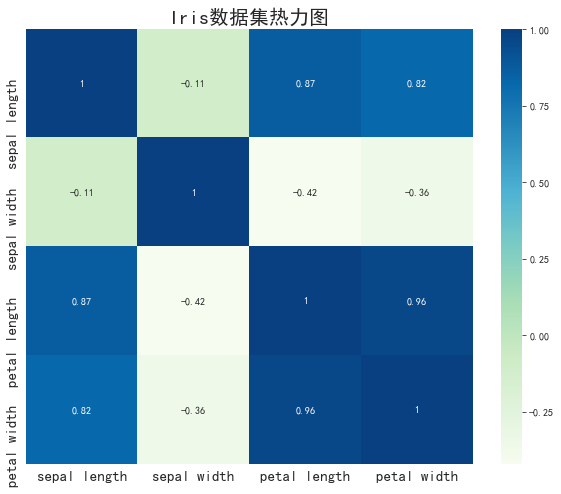

In [192]:
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
features_mean= list(iris.columns[0:4])
# 使用热力图呈现features_mean 字段之间的相关性
corr = iris[features_mean].corr()
plt.figure(figsize=(10,8))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True,cmap='GnBu')
plt.title('Iris数据集热力图',fontsize = 20)
plt.tick_params(labelsize=15)
plt.show()

选择与其他属性列相关性较强的petal length作为回归的目标属性，其他属性作为特征属性，并删除类别属性'class'.

In [193]:
# 删除类别属性列
iris=iris.drop(['class'],axis=1)
iris.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [194]:
X,y =iris.drop(['petal length'],axis=1),iris['petal length']
X_trains = []
X_tests = []
y_trains = []
y_tests = []
for i in np.arange(0.2,0.8,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30,test_size=(1-i))
    transfer = StandardScaler()
    X_train = transfer.fit_transform(X_train)
    X_test = transfer.fit_transform(X_test)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

# 2.1鸢尾花数据集使用随机森林回归

In [195]:
#构建回归器
my_rfc = RandomForestRegressor(n_estimators=25)
y_predicts = []
#在不同的测试集和训练集上进行训练和预测，预测结果保存在y_predicts中
for i in range(len(X_trains)):
    my_rfc.fit(X_trains[i],y_trains[i])
    y_predict = my_rfc.predict(X_tests[i])
    y_predicts.append(y_predict)
MSEs,MAEs,RMSEs,Rs = [],[],[],[]
for i in range(len(y_tests)):
    MSEs.append(mean_squared_error(y_tests[i],y_predicts[i]))
    MAEs.append(mean_absolute_error(y_tests[i],y_predicts[i]))
    RMSEs.append(np.sqrt(mean_squared_error(y_tests[i],y_predicts[i])))
    Rs.append(r2_score(y_tests[i],y_predicts[i]))

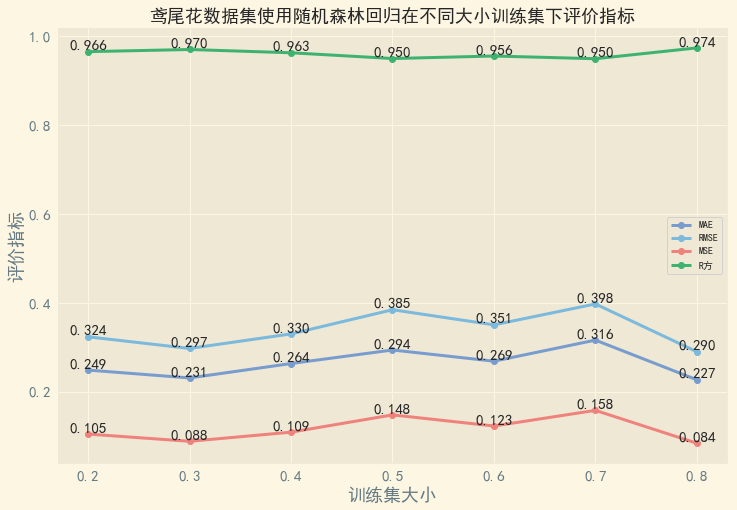

In [196]:
%matplotlib inline
x = list(np.arange(0.2,0.8,0.1))
# 数据处理，保留4位小数
plt.style.use('Solarize_Light2')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.plot(x, MAEs, label='MAE', linewidth=3, color='#789CCE', marker='o',markerfacecolor='#789CCE')
plt.plot(x, RMSEs, label='RMSE', linewidth=3, color='#7bb9dd', marker='o',markerfacecolor='#7bb9dd')
plt.plot(x, MSEs, label='MSE', linewidth=3, color='#EF827D', marker='o',markerfacecolor='#EF827D')
plt.plot(x, Rs, label='R方', linewidth=3, color='#3eb370', marker='o',markerfacecolor='#3eb370')
plt.xlabel('训练集大小',fontsize = 18)
# 纵坐标描述
plt.ylabel('评价指标',fontsize = 18)
# 标题
plt.title('鸢尾花数据集使用随机森林回归在不同大小训练集下评价指标',fontsize = 18)
plt.legend()
# 设置数字标签
for a, b in zip(x, MAEs):
    plt.text(a, b,'{:.3f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, MSEs):
    plt.text(a, b, '{:.3f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, Rs):
    plt.text(a, b,'{:.3f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, RMSEs):
    plt.text(a, b, '{:.3f}'.format(b), ha='center', va='bottom',fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

# 2.2鸢尾花数据集使用Adaboost回归



In [197]:
#以决策树回归为基回归器
rgr_tree = DecisionTreeRegressor(max_depth=4)#决策树回归
rgr_ada = AdaBoostRegressor(rgr_tree,n_estimators=300, random_state=25)#AdaBoost回归

y_predicts = []
#在不同的测试集和训练集上进行训练和预测，预测结果保存在y_predicts中
for i in range(len(X_trains)):
    rgr_ada.fit(X_trains[i],y_trains[i])
    y_predict = rgr_ada.predict(X_tests[i])
    y_predicts.append(y_predict)
MSEs,MAEs,RMSEs,Rs = [],[],[],[]
for i in range(len(y_tests)):
    MSEs.append(mean_squared_error(y_tests[i],y_predicts[i]))
    MAEs.append(mean_absolute_error(y_tests[i],y_predicts[i]))
    RMSEs.append(np.sqrt(mean_squared_error(y_tests[i],y_predicts[i])))
    Rs.append(r2_score(y_tests[i],y_predicts[i]))

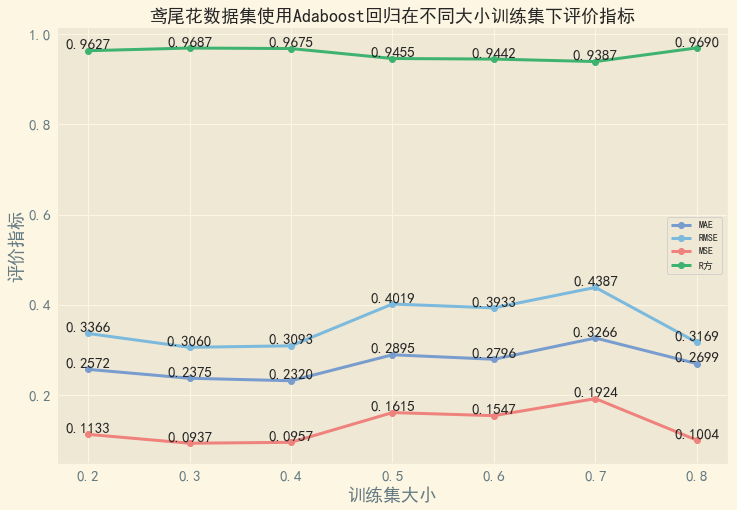

In [198]:
%matplotlib inline
x = list(np.arange(0.2,0.8,0.1))
plt.style.use('Solarize_Light2')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.plot(x, MAEs, label='MAE', linewidth=3, color='#789CCE', marker='o',markerfacecolor='#789CCE')
plt.plot(x, RMSEs, label='RMSE', linewidth=3, color='#7bb9dd', marker='o',markerfacecolor='#7bb9dd')
plt.plot(x, MSEs, label='MSE', linewidth=3, color='#EF827D', marker='o',markerfacecolor='#EF827D')
plt.plot(x, Rs, label='R方', linewidth=3, color='#3eb370', marker='o',markerfacecolor='#3eb370')
plt.xlabel('训练集大小',fontsize = 18)
# 纵坐标描述
plt.ylabel('评价指标',fontsize = 18)
# 标题
plt.title('鸢尾花数据集使用Adaboost回归在不同大小训练集下评价指标',fontsize = 18)
plt.legend()
# 设置数字标签
for a, b in zip(x, MAEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, MSEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, Rs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
for a, b in zip(x, RMSEs):
    plt.text(a, b, '{:.4f}'.format(b), ha='center', va='bottom',fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

# 2.3 算法性能比较

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30,test_size=0.3)
my_rfc = RandomForestRegressor(n_estimators=25)
my_rfc.fit(X_train,y_train)
y_predict_forest = my_rfc.predict(X_test)
MSE_forest = mean_squared_error(y_test,y_predict_forest)
MAE_forest = mean_absolute_error(y_test,y_predict_forest)
RMSE_forest = np.sqrt(mean_squared_error(y_test,y_predict_forest))
R2_forest = r2_score(y_test,y_predict_forest)

In [171]:
#以决策树回归为基回归器
rgr_tree = DecisionTreeRegressor(max_depth=4)#决策树回归
rgr_ada = AdaBoostRegressor(rgr_tree,n_estimators=300, random_state=25)#AdaBoost回归
rgr_ada.fit(X_train,y_train)
y_predict_adaboost = rgr_ada.predict(X_test)
MSE_adaboost = mean_squared_error(y_test,y_predict_adaboost)
MAE_adaboost = mean_absolute_error(y_test,y_predict_adaboost)
RMSE_adaboost = np.sqrt(mean_squared_error(y_test,y_predict_adaboost))
R2_adaboost = r2_score(y_test,y_predict_adaboost)

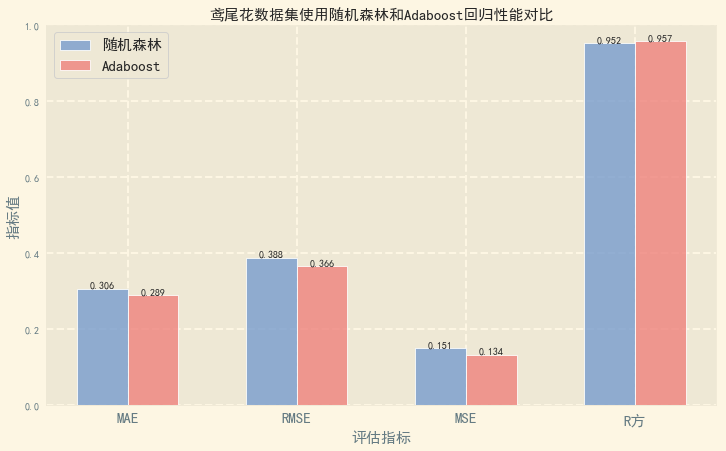

In [174]:
# 对比鸢尾花数据集在随机森林和Adaboost上的性能
forest_list=[MAE_forest,RMSE_forest,MSE_forest,R2_forest]
adaboost_list=[MAE_adaboost,RMSE_adaboost,MSE_adaboost,R2_adaboost]
plt.style.use('Solarize_Light2')
def autolabel(rects):
    for i in rects:
        h = i.get_height()
        plt.text(i.get_x() + i.get_width() / 2, h, '{:.3f}'.format(h), ha='center', va='bottom')
x = np.array(list(range(1,5)))
bar_width=0.3
plt.figure(figsize=(12,7))
plot_forest = plt.bar(x-bar_width/2, forest_list, width=bar_width,align='center',label = '随机森林',alpha = 0.8,color = '#789CCE')
plot_adaboost = plt.bar(x+bar_width/2,adaboost_list, width=bar_width,align='center',label = 'Adaboost',alpha = 0.8,color = '#EF827D')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.xlabel('评估指标',size = 15)
plt.ylabel('指标值',size = 15)
plt.ylim([0,1])
autolabel(plot_forest)
autolabel(plot_adaboost)
plt.title('鸢尾花数据集使用随机森林和Adaboost回归性能对比',size = 15)
plt.grid(b = True,ls = '--',linewidth = 2)
plt.xticks(x,["MAE","RMSE","MSE","R方"] ,size = 15)
plt.legend(loc ='upper left',fontsize = 15)
plt.show()